# Deep Q-Learning in Atari Gym CartPole

We're going to be building and training a deep Q-network to learn to balance a pole on a moving cart. This is widely known as the cart and pole problem. 

The goal of CartPole is to balance a pole connected with one joint on top of a moving cart. An agent can move the cart by performing a series of 0 or 1 actions, pushing it left or right. A reward of +1 is awarded each second the pole is kept straight up.


In [1]:
%%bash

# !apt update
apt install -y python-opengl ffmpeg > /dev/null 2>&1
# !apt install -y xvfb
pip install pyvirtualdisplay gym[atari] gym[box2d] gym[classic_control]
# WORKAROUND: retry ---v
pip install gym[box2d]
pip install --no-deps baselines

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for baselines: filename=baselines-0.1.5-py3-none-any.whl size=163902 sha256=a7572e45d4bf73391b7ae88e99e165d3cd72285f52f3c8fb0f2265a9f6f27864
  Stored in directory: /root/.cache/pip/wheels/64/27/40/3b266f230c825e6b219bfdd5447566d4d109b66fc4e0c074ed
Successfully built baselines


## Importing necessary libraries

In [2]:
import math
import random
from typing import Text, Dict, List, NamedTuple, Tuple, Optional, Union
from collections import namedtuple
from itertools import count
from PIL import Image

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 
from IPython import display

**Displaying the plot inside the kernel**

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

**Creating a virtual display in the background**

In [4]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=0,  # use False with Xvfb
                                    size=(400, 300))
_display.start()

## Deep Q Network

In [5]:
class DQN(nn.Module):
    def __init__(self, num_state_features):
        """
           num_state_features: [cart_position,
                                cart_velocity,
                                pole_angle,
                                pole_velocity_at_tip]
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features=num_state_features,
                             out_features=32)

        self.fc2 = nn.Linear(in_features=32,
                             out_features=64)
        
        self.fc3 = nn.Linear(in_features=64,
                             out_features=128)
        
        self.out = nn.Linear(in_features=128,
                             out_features=2) 
    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t

Using the replay memory, we will create an experience class to help train the network

In [6]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

**Display the experience display format**

In [7]:
e = Experience(2, 3, 1, 4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [2]:
class ReplayMemeory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience) -> None:
        """
          Args:
            experience
        """
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            self.push_count += 1

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size: int) -> bool:
        
        return len(self.memory) >= batch_size

Using Epsilon Greedy Strategy

In [9]:
class EpsilonGreedyStrategy:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return self.end + (self.start - self.end) *\
                math.exp(-1. * current_step * self.decay)

In [10]:
class Agent:
    def __init__(self, strategy, num_actions, device) -> None:
        """
          strategy: represent an instance from EpsilonGreedyStrategy
          num_actions: corresponding to how many possible actions
                       can the agent take from a given state.
        """
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        self.device = device

    def select_action(self, state, policy_net) -> float:
       
        epsilon_rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if epsilon_rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device=self.device) # explore
        else:
            with torch.no_grad():
                return policy_net(state).\
                       unsqueeze(dim=0).\
                       argmax(dim=1).\
                       to(device=self.device) # exploit

## CartPole Environment

In [11]:
class CartPoleEnvManager:
    def __init__(self, device) -> None:
        
        self.device = device
        self.env = gym.make('CartPole-v1').unwrapped
        self.env.reset() 
        self.current_screen = None
        self.current_state = None
        self.done = False

    def reset(self) -> None:
       
        self.current_state = self.env.reset()

    def close(self) -> None:
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def display(self):
        return self.env.display()

    def num_actions_available(self):
       
        return self.env.action_space.n

    def take_action(self, action: torch.Tensor) -> torch.Tensor:
        
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def get_state(self):
        
        if self.done:
            return torch.zeros_like(
              torch.tensor(self.current_state, device=self.device)
            ).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()

    def num_state_features(self):
        return self.env.observation_space.shape[0]
    
    def image_reset(self) -> None:
        self.env.reset()
        self.current_screen = None 
    
    def get_image_state(self):
        """Return the current state of the environment in the form of
           a processed image of the screen.
        """
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def just_starting(self) -> bool:
        """Check whether the the current screen is None or not
            This help to check if we're at the start of the environment or not!
        """
        return self.current_screen is None

    def get_screen_height(self) -> int:
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self) -> int:
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        """Get the image's color channels then transpose the channels
        into the order of channels by height and width which what PyTorch DQN expect  
        """
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        """Except screen and will return a cropped version of it"""
        screen_height = screen.shape[1]

        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]

        return screen

    def transform_screen_data(self, screen):
        # Convert to float, then resize and then convert to tensor
        screen = np.ascontiguousarray(screen,
                                      dtype=np.float32) / 255 
        
        screen = torch.from_numpy(screen)

        resize = T.Compose([
                           T.ToPILImage(),
                           T.Resize((40,90)),
                           T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device)
  

## Example of non-processed screen

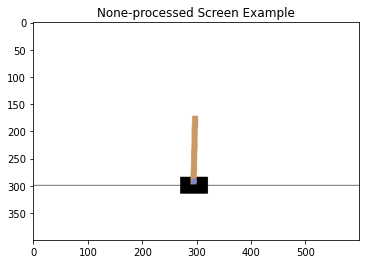

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_em = CartPoleEnvManager(device)
image_em.image_reset()
screen = image_em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('None-processed Screen Example')
plt.show()

## Example of processed screen

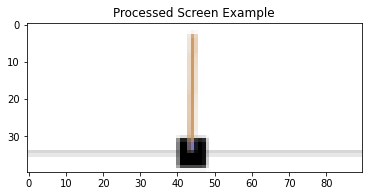

In [13]:
screen = image_em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Processed Screen Example')
plt.show()

## Example of starting state

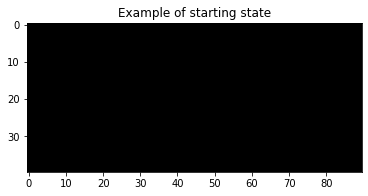

In [14]:
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of starting state')
plt.show()

## Example of None-starting state

This shape due to taking the differences between the first and the second screen

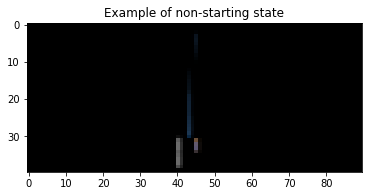

In [15]:
for i in range(5):
    image_em.take_action(torch.tensor([1]))
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of non-starting state')
plt.show()

## Example of End state

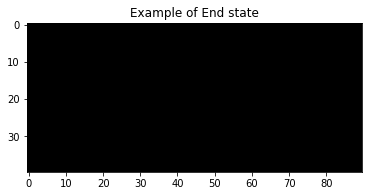

In [16]:
image_em.done = True
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of End state')
plt.show()

### Tensor Processing

In [17]:
def extract_tensors(experiences: NamedTuple) -> Tuple[torch.TensorType]:
   
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    # t_states = torch.cat(batch.state)
    t_states = torch.stack(batch.state)
    t_actions = torch.cat(batch.action)
    # t_next_state = torch.cat(batch.next_state)
    t_next_state = torch.stack(batch.next_state)
    t_rewards = torch.cat(batch.reward)


    return (t_states,
            t_actions,
            t_next_state,
            t_rewards)

#### **Example of `Experience(*zip(*experiences))` used above**



In [18]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

Now, let's illustrate that in a form of `batch` instead of having it a form of `samples`.

In [19]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Q-Value Calculator

In [20]:
class QValues:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_states_location = next_states.flatten(start_dim=1)\
          .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_states_locations = (final_states_location == False)
        non_final_states = next_states[non_final_states_locations]
        
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        values[non_final_states_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        
        return values

### Moving Average Plot

To solve cart and pole, the average reward must be greater than or equal to `195` over <u>`100` consecutive episodes</u>. Recall that our agent gets a reward of `+1` for each step it takes that doesn't end the episode. So, the duration of an episode measured in timesteps is exactly equivalent to the reward for that episode. 

In [21]:
def plot(values, # Episode Durations
         moving_avg_period,
         env=None): # 100 episodes moving average
    moving_avg = get_moving_average(moving_avg_period, values)
    # plt.figure(2)
    figure, axes = plt.subplots(1, 2, figsize=(21, 6),
                              gridspec_kw={'width_ratios': [4, 6],
                                           'wspace':0.025, 'hspace':0.025})

    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.clf()
    axes[0].set_title('Training...')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Duration')
    axes[0].plot(values)
    axes[0].plot(moving_avg)
    if env:
        axes[1].set_title('Cart Pole Rendering')
        axes[1].grid(False)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(env.render('rgb_array'))
    else:
        axes[1].set_axis_off()
    plt.pause(0.001)
    print(f"- Episodes: {len(values)}\n- {moving_avg_period} episodes moving avg: {moving_avg[-1]}")
    if is_ipython: display.clear_output(wait=True)

In [22]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)

    if len(values) >= period:

        moving_avg = values.unfold(dimension=0,size=period,step=1).mean(dim=1).flatten(start_dim=0)
        
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()    

**Example for plotting values**

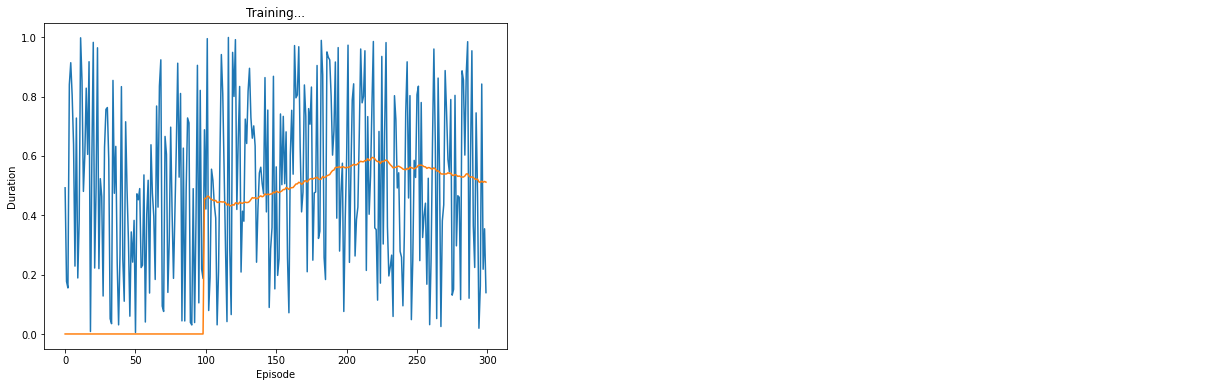

- Episodes: 300
- 100 episodes moving avg: 0.5114134550094604


In [23]:
plot(np.random.rand(300), 100)

 The actual values are plotted in blue, and the orange line is the `100-period` moving average across these values.

We can see that the `100-period` moving average is `0` for the first `99` values, and then we get the first calculated moving average at the `100th` value. This represents the average of the first `100` values in the array. If we skip over to the moving average at value `200`, then the orange line at this point represents the average of the second `100` values between value `100` to `200`. 

### Global Hyperparameters

In [24]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10

memory_size = 100000
lr = 0.001
num_episodes = 1000

### Main objects

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemeory(memory_size)

policy_net = DQN(em.num_state_features()).to(device)

target_net = DQN(em.num_state_features()).to(device)

### Updating the policies

Get the `target_network` weights from `policy_network` wieghts

In [26]:
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

Evaluate the `target_network` – also, we're telling the network that this network is not on the training mode, in other words it is only used in inference.

In [27]:
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

Update the weights in the `policy_network`

In [28]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

### Training Mode

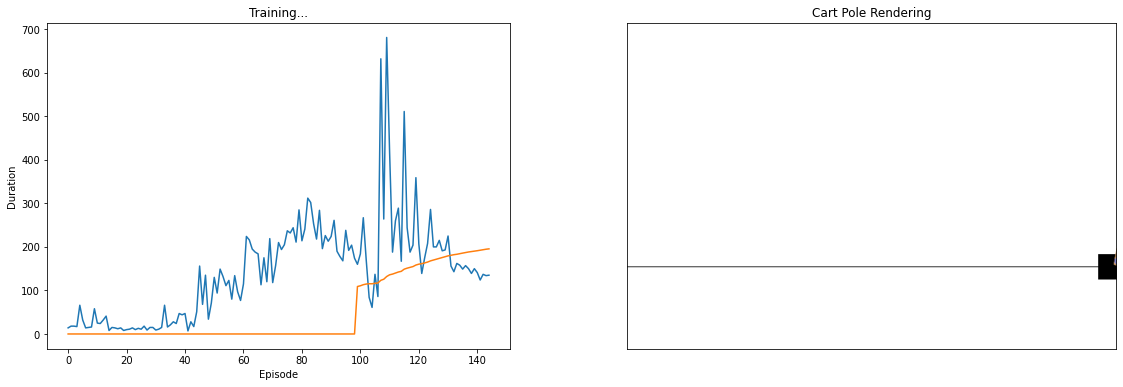

- Episodes: 145
- 100 episodes moving avg: 195.49000549316406


In [29]:
episode_duration = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_states = em.get_state()
        memory.push(Experience(state, action, next_states, reward))
        state = next_states

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, next_states, rewards = extract_tensors(experiences)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = rewards + (gamma * next_q_values)
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if em.done:
            episode_duration.append(timestep)
            plot(episode_duration, 100, em) # plot the duration by 100 moving average
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if get_moving_average(100, episode_duration)[-1] >= 195:
        break

em.close()

Goal is to reach a moving avg greater than 195 which was achieved after 145 episodes

**Establish a baseline performance. How well did your Deep Q-learning do on your problem? (5 Points)Links to an external site. For example total_episodes = 5000 total_test_episodes = 100 max_steps = 99 learning_rate = 0.7 gamma = 0.8 epsilon = 1.0 max_epsilon = 1.0 min_epsilon = 0.01 decay_rate = 0.01 With this baseline performance, our RL program with the Taxi-v2 Toy text gives us a score of 8.13, which is considered not bad.**

Before the model was trained, we were getting negative scores for the player, but after training, we started getting positive scores

**What are the states, the actions, and the size of the Q-table?**

States:  [cart position, cart velocity, pole angle, pole angular velocity]

Actions: [left, right]

Size of Q-Table: 8

**What are the rewards? Why did you choose them?**

The agent recieves a +1 reward every second that the pole remains upright. This was done to prevent the pole from falling over

**How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?**

The fastest solution was achieved in 265 episodes, with gamma = 0.995 and learning rate = 0.15. Overall the results seem to be better, with the higher gamma around 0.995

**Try a policy other than e-greedy. How did it change the baseline performance?**

It is possible to do this experiment using a MemoryData Layer, a Softmax layer and a MemoryLoss layer. However, this process is better

**Does Q learning use value-based or policy-based iteration**

Q-learning is a value-based reinforcement learning algorithm, which means that it learns a value function that estimates the expected return for taking a given action in a given state. The value function, also known as the Q-function, is used to determine the optimal action to take in each state, with the goal of maximizing the expected return over time.

In contrast, policy-based reinforcement learning algorithms learn a policy directly, without estimating a value function. The policy specifies the action to take in each state, and the goal is to maximize the expected return by following the policy.

Both value-based and policy-based algorithms can be used to learn optimal policies for interacting with an environment, but they differ in how they represent and update their knowledge about the environment. Value-based algorithms learn a value function that estimates the long-term return of each action in each state, while policy-based algorithms learn a policy that specifies the action to take directly.




**Could you use SARSA for this problem?**

Yes, it is possible.

To use the SARSA algorithm to solve the CartPole environment, you would first need to define the action-value function, which estimates the expected return for taking a given action in a given state. The state in this case would include information about the position and velocity of the cart and pole, and the action would be either applying force to the left or to the right.

You would then need to define a policy for the agent to follow, which could be either deterministic or stochastic. The policy could be based on the action-value function, with the agent taking the action with the highest estimated return in each state.

Next, you would need to interact with the environment and update the action-value function using the SARSA update rule. This would involve the agent selecting an action based on its current policy, receiving a reward and new state from the environment, and updating the action-value for the state and action it just took. The process would continue until the action-value function converges to a stable value, at which point the agent is said to have learned an optimal policy for the CartPole environment.

**What is meant by expected lifetime value in the Bellman equation**

The expected lifetime value is a measure of the expected return for a given policy over an infinite horizon. It is defined as the sum of the expected rewards at each time step, discounted by the discount factor, γ, which determines how much the agent values future rewards versus immediate rewards.

The expected lifetime value can be represented using the Bellman equation, which defines the value of a state in terms of the expected value of the next state and the reward received for transitioning between the two states. The Bellman equation is used in value-based reinforcement learning algorithms, such as Q-learning, to learn a value function that estimates the expected return for taking a given action in a given state.

In the case of the Bellman equation, the expected lifetime value is represented by the term max(Q(s', a')), which is the maximum expected return over all possible actions in the next state. The expected lifetime value is then used to update the current value of the state and action using the following update rule:

Q(s, a) = Q(s, a) + α[R + γmax(Q(s', a')) - Q(s, a)]

Here, s and s' are the current and next states, respectively, a and a' are the current and next actions, R is the reward received for taking action a in state s, α is the learning rate, and γ is the discount factor. The expected lifetime value is the term max(Q(s', a')), which represents the maximum expected return over all possible actions in the next state.

It helps the agent balance the trade-off between immediate and future rewards. By discounting future rewards, the agent can weigh the importance of immediate rewards versus the potential benefits of waiting for a larger reward later on. This allows the agent to make more informed decisions about which actions to take in order to maximize its expected return over time.

**When would SARSA likely do better than Q learning**

One situation where SARSA might perform better is when the environment is changing rapidly, and the value function learned by Q-learning becomes outdated. In these cases, SARSA, which is a on-policy algorithm, can adapt more quickly to changes in the environment because it updates the action-value function based on the current policy, rather than relying on an outdated value function.

Another situation where SARSA might perform better is when the value function learned by Q-learning is highly unstable or noisy. In these cases, SARSA, which updates the action-value function using a single sample, might be more stable than Q-learning, which updates the value function using the maximum action-value for the next state.

Finally, SARSA might perform better than Q-learning in environments where the optimal policy is not deterministic, and the agent needs to explore different actions in order to learn the best course of action. In these cases, SARSA, which updates the action-value function based on the action actually taken, rather than the action with the highest estimated return, might be more effective at learning a policy that takes into account the trade-off between exploration and exploitation.

**How does SARSA differ from Q learning**

One key difference between SARSA and Q-learning is that SARSA is a on-policy algorithm, while Q-learning is an off-policy algorithm. This means that SARSA learns about the environment by following the current policy, while Q-learning can learn about the environment and improve its decision-making over time without necessarily following the current policy.

Another difference between SARSA and Q-learning is the way they update their knowledge about the environment. SARSA updates the action-value function, which estimates the expected return for taking a given action in a given state, using a single sample from the environment. In contrast, Q-learning updates the value function, also known as the Q-function, using the maximum action-value for the next state.

A third difference between SARSA and Q-learning is the way they balance the trade-off between exploration and exploitation. SARSA updates the action-value function based on the action actually taken, which encourages the agent to explore different actions and potentially discover new, rewarding behaviors. In contrast, Q-learning updates the value function using the maximum action-value for the next state, which can lead to overestimation of the value of certain actions and result in the agent becoming too greedy and not exploring enough.

**Explain Q learning Algorithm**

Q-learning is a model-free reinforcement learning algorithm used to learn a policy telling an agent what action to take under what circumstances. It is an off-policy algorithm, meaning that it can learn about the environment and improve its decision-making over time without necessarily following the current policy.

The goal of Q-learning is to learn a function, called the Q-function, that takes in a state and an action and returns the expected reward for taking that action in that state. The Q-function is used to determine the optimal action to take in each state, with the goal of maximizing the expected reward over time.

To learn the Q-function, the agent needs to interact with the environment and receive rewards for its actions. At each time step, the agent selects an action based on its current policy and receives a reward and new state from the environment. The agent then updates the Q-value for the state and action it just took using the following update rule:

Q(s, a) = Q(s, a) + α[R + γmax(Q(s', a')) - Q(s, a)]

Here, s and s' are the current and next states, respectively, a and a' are the current and next actions, R is the reward received for taking action a in state s, α is the learning rate, and γ is the discount factor. The discount factor determines how much the agent values future rewards versus immediate rewards.

The Q-function is typically learned through a process called Q-learning, which involves the agent repeatedly taking actions in the environment, updating its Q-values based on the rewards it receives, and using the updated Q-values to improve its policy. This process continues until the Q-function converges to a stable value, at which point the agent is said to have learned an optimal policy.

**Explain the SARSA Algorithm**

SARSA (State-Action-Reward-State-Action) is a model-based reinforcement learning algorithm used to learn a policy for an agent interacting with an environment. Like Q-learning, it is used to determine the optimal action to take in each state, but it is a on-policy algorithm, meaning that it learns about the environment by following the current policy.

The goal of SARSA is to learn a function, called the action-value function, that estimates the expected return for taking a given action in a given state. The action-value function is used to determine the optimal policy for the agent, with the goal of maximizing the expected return over time.

To learn the action-value function, the agent needs to interact with the environment and receive rewards for its actions. At each time step, the agent selects an action based on its current policy and receives a reward and new state from the environment. The agent then updates the action-value for the state and action it just took using the following update rule:

Q(s, a) = Q(s, a) + α[R + γQ(s', a') - Q(s, a)]

Here, s and s' are the current and next states, respectively, a and a' are the current and next actions, R is the reward received for taking action a in state s, α is the learning rate, and γ is the discount factor. The discount factor determines how much the agent values future rewards versus immediate rewards.

The action-value function is learned through a process called SARSA, which involves the agent repeatedly taking actions in the environment, updating its action-values based on the rewards it receives, and using the updated action-values to improve its policy. This process continues until the action-value function converges to a stable value, at which point the agent is said to have learned an optimal policy.



**What code is yours and what have you adapted**

I have modified the code found in the article here and made changes according to the assignment: https://medium.com/analytics-vidhya/q-learning-is-the-most-basic-form-of-reinforcement-learning-which-doesnt-take-advantage-of-any-8944e02570c5

**References**

1. https://medium.com/analytics-vidhya/q-learning-is-the-most-basic-form-of-reinforcement-learning-which-doesnt-take-advantage-of-any-8944e02570c5
2. https://www.gymlibrary.dev
3. https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code
4. https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb
5. https://www.signalpop.com/tutorial_pg_softmax_cartpole/

## License

Copyright 2022 Jay Devnani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.